In [1]:
import pandas as pd
import numpy as np
import os
import sys

# Append the parent directory (root) to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from eda_toolkit import ensure_directory

from tqdm import tqdm
from aequitas.audit import Audit

from py_scripts.functions import perform_bootstrapped_audit, plot_metrics

## Set Paths

In [2]:
data_path = os.path.join(os.pardir, "public_data/")

In [3]:
# Create base path
base_path = os.path.join(os.pardir)

# create image paths
image_path_png = os.path.join(base_path, "images", "png_images")
image_path_svg = os.path.join(base_path, "images", "svg_images")

# Use the function to ensure'data' directory exists
ensure_directory(image_path_png)
ensure_directory(image_path_svg)

Directory exists: ../images/png_images
Directory exists: ../images/svg_images


In [4]:
df = pd.read_csv(os.path.join(data_path, "adult_predictions.csv")).set_index("Adult_ID")

In [5]:
df.head()  # inspect first 5 rows of data

,race,sex,income,predicted
Adult_ID,,,,
482204877,Asian-Pac-Islander,Male,1,1
351730626,Amer-Indian-Eskimo,Male,0,0
186467915,White,Male,0,1
451753915,White,Female,1,1
893237791,Black,Female,0,0


## Apply the Audit Method

In [6]:
audit = Audit(df=df, score_column="predicted", label_column="income")
audit.audit()

## Inspect Disparity DataFrame

In [7]:
audit.disparity_df

,model_id,score_threshold,k,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,...,ppr_ref_group_value,pprev_ref_group_value,precision_ref_group_value,fdr_ref_group_value,for_ref_group_value,fpr_ref_group_value,fnr_ref_group_value,tpr_ref_group_value,tnr_ref_group_value,npv_ref_group_value
0,0,binary 0/1,5607,race,Amer-Indian-Eskimo,0.691489,1.000000,0.650602,0.000000,0.725000,...,White,White,White,White,White,White,White,White,White,White
1,0,binary 0/1,5607,race,Asian-Pac-Islander,0.629508,0.963415,0.506726,0.025862,0.582011,...,White,White,White,White,White,White,White,White,White,White
2,0,binary 0/1,5607,race,Black,0.725720,0.982301,0.690534,0.003503,0.696721,...,White,White,White,White,White,White,White,White,White,White
3,0,binary 0/1,5607,race,Other,0.637500,1.000000,0.591549,0.000000,0.763158,...,White,White,White,White,White,White,White,White,White,White
4,0,binary 0/1,5607,race,White,0.643609,0.970311,0.532403,0.018628,0.586047,...,White,White,White,White,White,White,White,White,White,White
5,0,binary 0/1,5607,sex,Female,0.760802,0.926554,0.740471,0.012020,0.695450,...,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male
6,0,binary 0/1,5607,sex,Male,0.597214,0.978820,0.430864,0.020979,0.571523,...,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male


In [8]:
## output disparity dataframe to csv file in data path
audit.disparity_df.to_csv(os.path.join(data_path, "disparity_metrics.csv"))

In [9]:
seeds = list(range(2000))
n_iterations = 2000  # Number of bootstrapping iterations
sample_size = 5000  # Sample size for each iteration

stratify_columns = ["race"]
categorical_columns = [
    "sex",
    "race",
]
score_column = "predicted"
label_column = "income"
bootstrap_method = "stratified"  # stratify or 'balanced'

## Run Bootstrapped Disparity Metrics

In [10]:
results_dict = perform_bootstrapped_audit(
    df=df,
    seeds=seeds,
    n_iterations=n_iterations,
    sample_size=sample_size,
    stratify_columns=stratify_columns,
    categorical_columns=categorical_columns,
    score_column=score_column,
    label_column=label_column,
    return_disparity_metrics=True,
)

# Access the results
all_metrics_stratified = results_dict["all_metrics"]

Running audits: 100%|██████████| 2000/2000 [00:19<00:00, 100.85it/s]


In [11]:
all_metrics_stratified

,index,model_id,score_threshold,k,attribute_name,attribute_value,accuracy,tpr,tnr,for,...,ppr_ref_group_value,pprev_ref_group_value,precision_ref_group_value,fdr_ref_group_value,for_ref_group_value,fpr_ref_group_value,fnr_ref_group_value,tpr_ref_group_value,tnr_ref_group_value,npv_ref_group_value
0,0,0,binary 0/1,2877,sex,Female,0.756140,0.953368,0.731048,0.008050,...,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male
1,1,0,binary 0/1,2877,sex,Male,0.590937,0.983539,0.426166,0.015952,...,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male
2,2,0,binary 0/1,2877,race,Amer-Indian-Eskimo,0.666667,1.000000,0.636364,0.000000,...,White,White,White,White,White,White,White,White,White,White
3,3,0,binary 0/1,2877,race,Asian-Pac-Islander,0.608974,0.950000,0.491379,0.033898,...,White,White,White,White,White,White,White,White,White,White
4,4,0,binary 0/1,2877,race,Black,0.707724,1.000000,0.667458,0.000000,...,White,White,White,White,White,White,White,White,White,White
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,2,0,binary 0/1,2878,race,Amer-Indian-Eskimo,0.625000,1.000000,0.590909,0.000000,...,White,White,White,White,White,White,White,White,White,White
13996,3,0,binary 0/1,2878,race,Asian-Pac-Islander,0.634615,0.967742,0.552000,0.014286,...,White,White,White,White,White,White,White,White,White,White
13997,4,0,binary 0/1,2878,race,Black,0.720251,0.983607,0.681818,0.003497,...,White,White,White,White,White,White,White,White,White,White
13998,5,0,binary 0/1,2878,race,Other,0.600000,1.000000,0.555556,0.000000,...,White,White,White,White,White,White,White,White,White,White


In [12]:
metric_cols = [
    "pprev_disparity",
    "fpr_disparity",
    "tnr_disparity",
    "tpr_disparity",
    "fnr_disparity",
    "precision_disparity",
]

nondisparity_columns = [x.replace("_disparity", "") for x in metric_cols]

In [13]:
all_metrics_stratified["attribute_name"].value_counts()

attribute_name
race    10000
sex      4000
Name: count, dtype: int64

## Plot Disparity Metrics

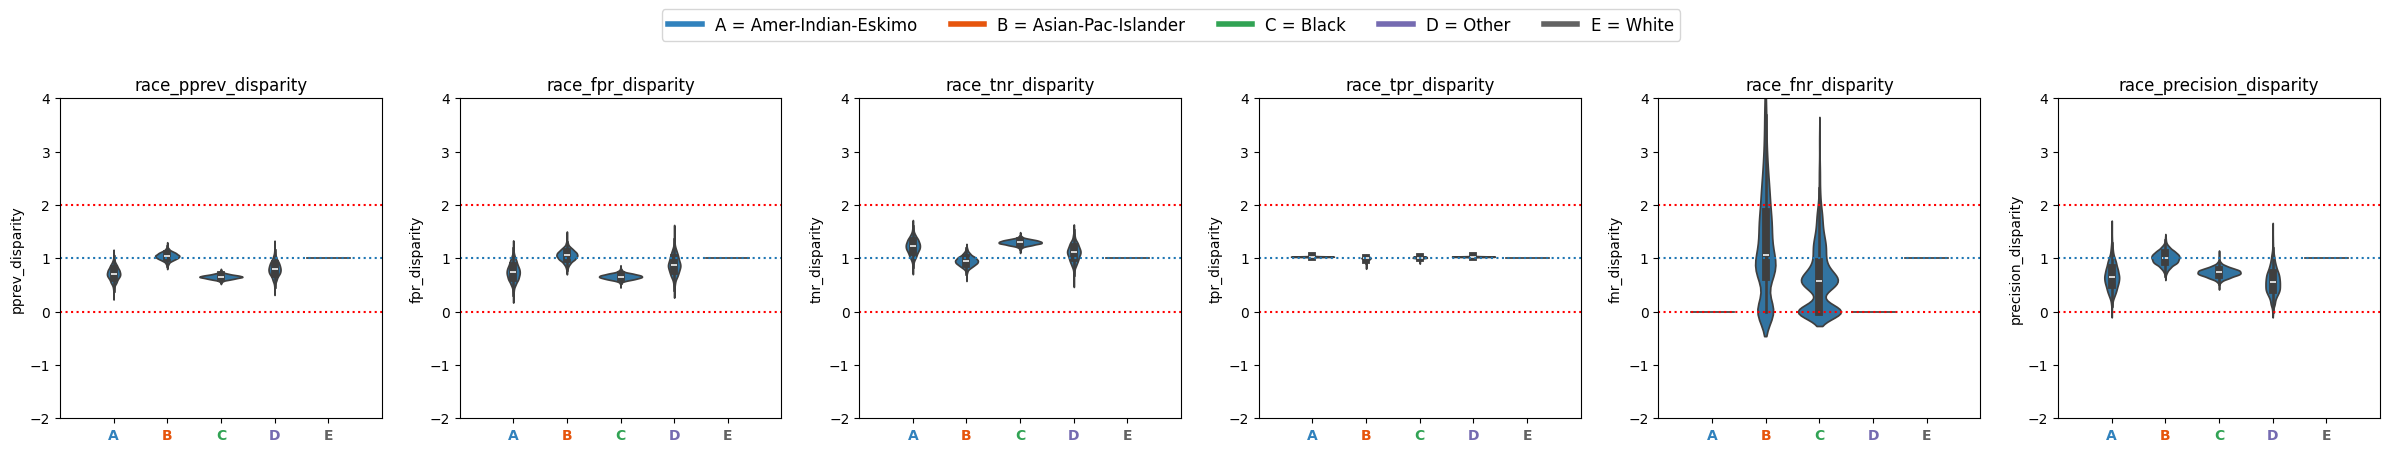

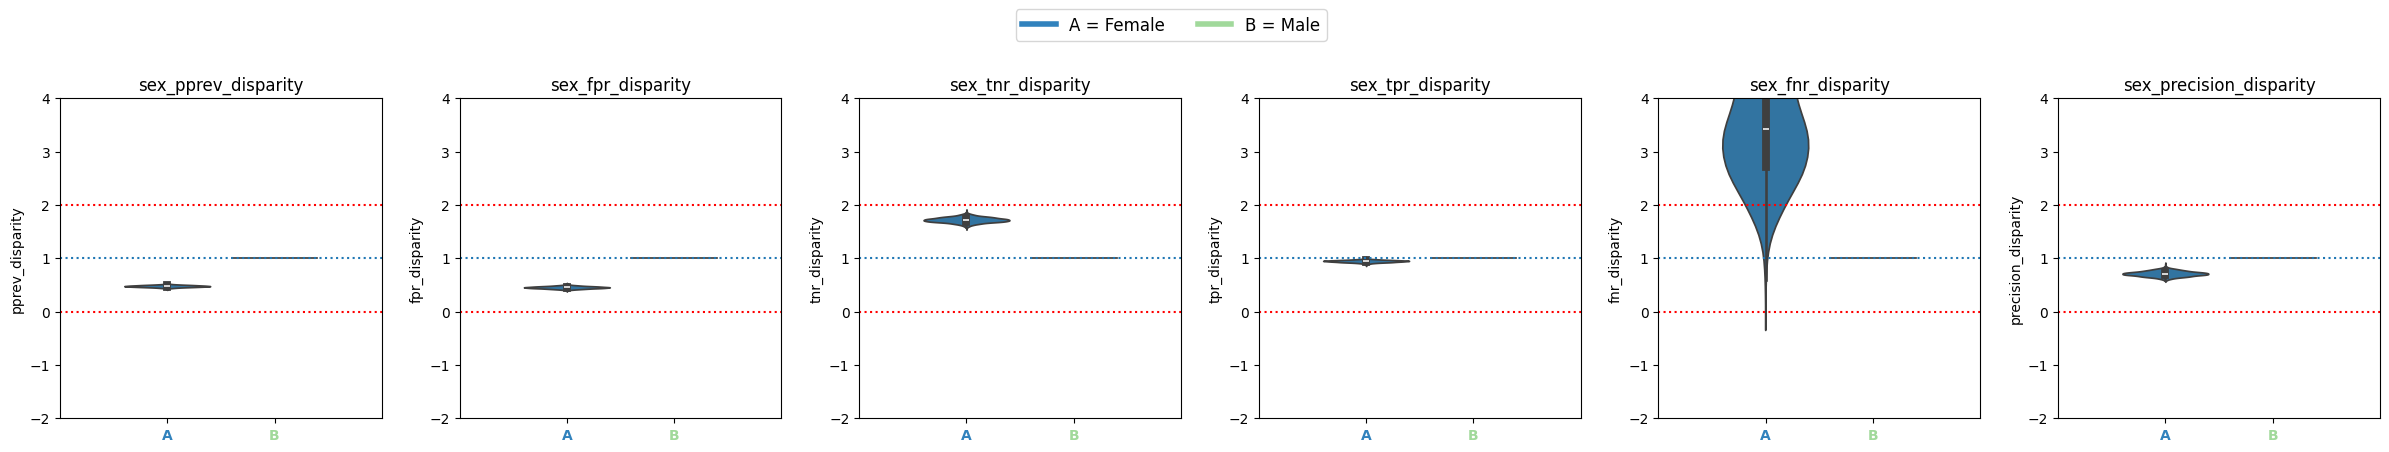

In [16]:
plot_metrics(
    all_metrics_stratified,
    categories="all",
    metric_cols=metric_cols,
    include_legend=True,
    save_plots=True,
    cmap="tab20c",
    image_path_png="image_path_png",
)